In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as dt


In [2]:
tickers = ['RELIANCE.NS', 'TCS.NS', 'INFY.NS']
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=5*365)
stock_data = {}
for ticker in tickers:
    stock_data[ticker] = yf.download(ticker , start=start_date , end=end_date)
    print(f"Downloaded {len(stock_data[ticker])} days of {ticker} data")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Downloaded 1237 days of RELIANCE.NS data


[*********************100%***********************]  1 of 1 completed


Downloaded 1238 days of TCS.NS data


[*********************100%***********************]  1 of 1 completed

Downloaded 1238 days of INFY.NS data


In [3]:
reliance=stock_data['RELIANCE.NS']
tcs=stock_data['TCS.NS']
infy=stock_data['INFY.NS']
print(reliance.head())
print(tcs.head())
print(infy.head())

Price            Close        High         Low        Open      Volume
Ticker     RELIANCE.NS RELIANCE.NS RELIANCE.NS RELIANCE.NS RELIANCE.NS
Date                                                                  
2020-03-30  461.245300  481.097046  456.567733  465.788617    30229866
2020-03-31  498.531647  505.715848  469.100937  480.716554    44292810
2020-04-01  483.626099  503.388294  467.847657  502.336398    41597459
2020-04-03  482.283234  507.797332  472.816168  507.797332    41367807
2020-04-07  539.869019  543.405140  492.376999  493.316995    54373624
Price             Close         High          Low         Open   Volume
Ticker           TCS.NS       TCS.NS       TCS.NS       TCS.NS   TCS.NS
Date                                                                   
2020-03-30  1665.491699  1783.953718  1651.491688  1653.785966  8513547
2020-03-31  1710.067505  1737.131189  1666.896774  1720.649536  3927593
2020-04-01  1600.174072  1718.167888  1593.852975  1709.880250  4941878


In [4]:
print(reliance.describe())

Price         Close         High          Low         Open        Volume
Ticker  RELIANCE.NS  RELIANCE.NS  RELIANCE.NS  RELIANCE.NS   RELIANCE.NS
count   1237.000000  1237.000000  1237.000000  1237.000000  1.237000e+03
mean    1132.252333  1144.214332  1121.198676  1133.046387  1.870978e+07
std      204.266439   204.601539   203.988581   204.326898  1.562956e+07
min      461.245300   481.097046   456.567733   465.788617  0.000000e+00
25%      994.095825  1009.929737   984.636152   995.865174  9.851910e+06
50%     1142.915649  1153.046551  1135.059347  1143.887973  1.376574e+07
75%     1245.900024  1258.385527  1233.805535  1246.966488  2.116033e+07
max     1590.069946  1597.916527  1574.774022  1593.595776  1.426834e+08


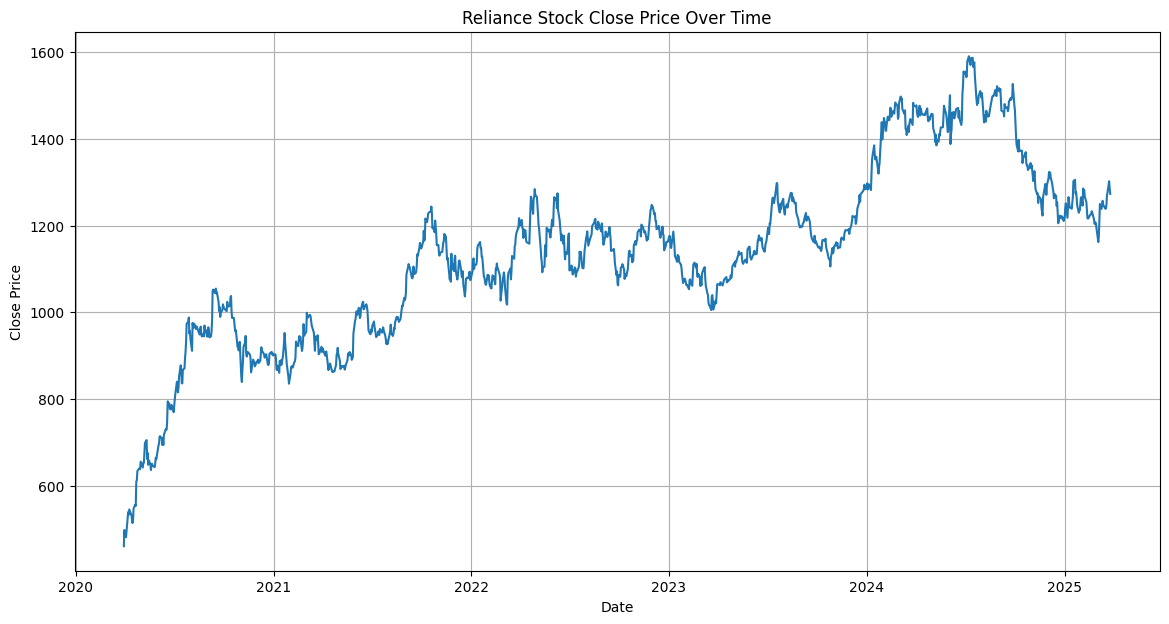

In [5]:
# Visualize the stock price over time
plt.figure(figsize=(14, 7))
plt.plot(reliance.index, reliance['Close'])
plt.title('Reliance Stock Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

as we can see from the plot there is seasonality and and an overall upward trend 

<Figure size 1400x1000 with 0 Axes>

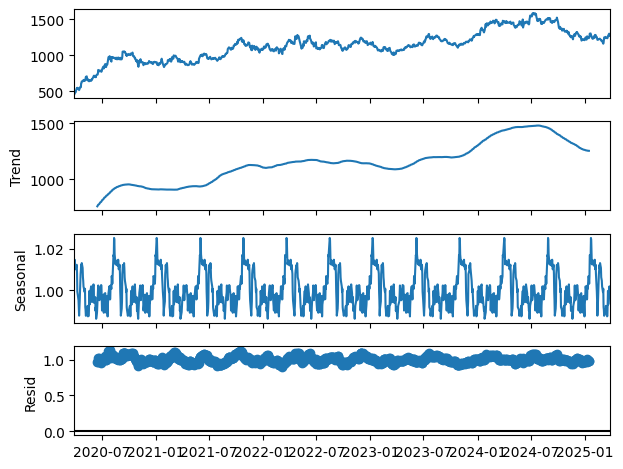

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
try :
    decomposition = seasonal_decompose(reliance['Close'],model = "multiplicative" , period = 100)
    fig = plt.figure(figsize=(14,10))
    fig = decomposition.plot()
    plt.show
except:
    print("Seasonal decomposition requires more data points.")


ir is clearly an upward trend with seasonality 

In [7]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(reliance['Close'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.180699
p-value: 0.021129


* The null hypothesis (H₀) states that the time series has a unit root, meaning it is non-stationary.
* The alternative hypothesis (H₁) suggests that the series is stationary.
* Significance Level (α = 0.02):
* If p-value < 0.02, reject H₀ (the series is stationary).
* If p-value > 0.02, fail to reject H₀ (the series is non-stationary).
* **therfore we reject null hypothesis as p>0.02 and we can say that it is not stationary**

In [8]:
 #Import specific indicator modules
from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.volatility import BollingerBands
from ta.volume import OnBalanceVolumeIndicator, VolumePriceTrendIndicator


so the structure of the dataframe has a multi index so i have to access it property 

In [9]:
def add_indicators(df):
    df= df.copy()
    #to take only price :
    close_price = df[('Close','RELIANCE.NS')]
    high_price =df[('High','RELIANCE.NS')]
    low_price= df[('Volume','RELIANCE.NS')]
    volume= df[('Low','RELIANCE.NS')]
    df['sma7']=SMAIndicator(close=close_price,window=7).sma_indicator()
    df['sma21']=SMAIndicator(close=close_price, window=21).sma_indicator()
    df['ema30']=EMAIndicator(close=close_price, window=30).ema_indicator()

    #MACD
    macd = MACD(close=close_price)
    df['MACD'] = macd.macd()
    df['MACD_Signal'] = macd.macd_signal()
    df['MACD_diff']= macd.macd_diff()
    #RSI
    df['rsi']= RSIIndicator(close=close_price).rsi()

    #  Bollinger Bands
    bollinger = BollingerBands(close=close_price)
    df['bollinger_mavg'] = bollinger.bollinger_mavg()
    df['bollinger_high'] = bollinger.bollinger_hband()
    df['bollinger_low'] = bollinger.bollinger_lband()

    #  Stochastic Oscillator
    stoch = StochasticOscillator(high=high_price, low=low_price, close=close_price)
    df['stoch_k'] = stoch.stoch()
    df['stoch_d'] = stoch.stoch_signal()
    #Volume Indicators
    df['obv'] = OnBalanceVolumeIndicator(close=close_price, volume= volume).on_balance_volume()
    df['vpt'] = VolumePriceTrendIndicator(close=close_price, volume= volume).volume_price_trend()
    # Price-based features
    df['return_1d'] = close_price.pct_change(1)
    df['return_5d'] = close_price.pct_change(5)
    df['return_10d'] = close_price.pct_change(10)
    
    # Volatility
    df['volatility_10d'] = df['return_1d'].rolling(window=10).std()
    
    return df

reliance_with_indicators = add_indicators(reliance)
print(reliance_with_indicators.head())
    

Price            Close        High         Low        Open      Volume sma7  \
Ticker     RELIANCE.NS RELIANCE.NS RELIANCE.NS RELIANCE.NS RELIANCE.NS        
Date                                                                          
2020-03-30  461.245300  481.097046  456.567733  465.788617    30229866  NaN   
2020-03-31  498.531647  505.715848  469.100937  480.716554    44292810  NaN   
2020-04-01  483.626099  503.388294  467.847657  502.336398    41597459  NaN   
2020-04-03  482.283234  507.797332  472.816168  507.797332    41367807  NaN   
2020-04-07  539.869019  543.405140  492.376999  493.316995    54373624  NaN   

Price      sma21 ema30 MACD MACD_Signal  ... bollinger_high bollinger_low  \
Ticker                                   ...                                
Date                                     ...                                
2020-03-30   NaN   NaN  NaN         NaN  ...            NaN           NaN   
2020-03-31   NaN   NaN  NaN         NaN  ...            NaN

In [10]:
print(reliance.index)
print(reliance.columns)


DatetimeIndex(['2020-03-30', '2020-03-31', '2020-04-01', '2020-04-03',
               '2020-04-07', '2020-04-08', '2020-04-09', '2020-04-13',
               '2020-04-15', '2020-04-16',
               ...
               '2025-03-12', '2025-03-13', '2025-03-17', '2025-03-18',
               '2025-03-19', '2025-03-20', '2025-03-21', '2025-03-24',
               '2025-03-25', '2025-03-26'],
              dtype='datetime64[ns]', name='Date', length=1237, freq=None)
MultiIndex([( 'Close', 'RELIANCE.NS'),
            (  'High', 'RELIANCE.NS'),
            (   'Low', 'RELIANCE.NS'),
            (  'Open', 'RELIANCE.NS'),
            ('Volume', 'RELIANCE.NS')],
           names=['Price', 'Ticker'])


In [11]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


In [12]:
def prepare_train_test(df, target_column='Close', test_size=0.2):
    df_clean = df.dropna()
    X = df_clean.drop(columns=[target_column])
    y = df_clean[target_column]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, X.columns


In [13]:
def run_lasso_and_select(X_scaled, y, feature_names):
    lasso = LassoCV(cv=5, random_state=0, max_iter=  10000)
    lasso.fit(X_scaled, y.values.ravel())
    selected = pd.Series(lasso.coef_, index=feature_names)
    selected = selected[selected != 0]
    return selected.sort_values(ascending=False), lasso


In [14]:
# Reliance
df = add_indicators(reliance)
X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, feature_names = prepare_train_test(df)
selected_features, lasso_model = run_lasso_and_select(X_train_scaled, y_train, feature_names)

print("Selected features:")
print(selected_features)


Selected features:
Price           Ticker     
High            RELIANCE.NS    76.431705
Low             RELIANCE.NS    76.029887
sma7                           29.774966
return_1d                       6.369500
vpt                             5.585005
return_5d                       2.609334
sma21                           1.524692
rsi                             0.822637
bollinger_mavg                  0.168163
bollinger_low                   0.161425
Volume          RELIANCE.NS    -0.097187
dtype: float64


In [15]:
relevant_features = list(selected_features.index)
flat_features = [f"{col[0]}" if isinstance(col, tuple) else col for col in relevant_features]

flat_features.append('Close')

df_filtered = df[flat_features].dropna()



In [16]:
from sklearn.preprocessing import MinMaxScaler

In [17]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_filtered)


In [18]:
# Save the scaler so you can inverse later
import joblib
joblib.dump(scaler, 'scaler.save')


['scaler.save']

In [ ]:
df_scaled = pd.DataFrame(scaled, columns=df_filtered.columns)
df_scaled.to_csv("df_for_gru_scaled.csv", index=False)